In [ ]:
#!nvidia-smi.exe

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML


In [ ]:
! pip install -q kaggle


In [ ]:
 ! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tommyngx/kneeoa

 97% 198M/204M [00:03<00:00, 62.5MB/s]
100% 204M/204M [00:03<00:00, 62.7MB/s]


In [ ]:
! unzip /content/kneeoa.zip -d 'kneeoa'

Streaming output truncated to the last 5000 lines.
  inflating: kneeoa/train/0/9684605R.png  
  inflating: kneeoa/train/0/9685238L.png  
  inflating: kneeoa/train/0/9685238R.png  
  inflating: kneeoa/train/0/9686617L.png  
  inflating: kneeoa/train/0/9686617R.png  
  inflating: kneeoa/train/0/9686777R.png  
  inflating: kneeoa/train/0/9686834L.png  
  inflating: kneeoa/train/0/9686834R.png  
  inflating: kneeoa/train/0/9686908L.png  
  inflating: kneeoa/train/0/9686908R.png  
  inflating: kneeoa/train/0/9687273L.png  
  inflating: kneeoa/train/0/9689906R.png  
  inflating: kneeoa/train/0/9690910L.png  
  inflating: kneeoa/train/0/9690910R.png  
  inflating: kneeoa/train/0/9691359L.png  
  inflating: kneeoa/train/0/9691359R.png  
  inflating: kneeoa/train/0/9692163L.png  
  inflating: kneeoa/train/0/9692604L.png  
  inflating: kneeoa/train/0/9692604R.png  
  inflating: kneeoa/train/0/9692923R.png  
  inflating: kneeoa/train/0/9693364R.png  
  inflating: kneeoa/train/0/9693599L.png  
  i

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### look at training set class balance

In [ ]:
import os
train_dir='/content/kneeoa/train'
classes=[os.listdir(train_dir)]
class_count=len(classes[0])
for klass in classes[0]:

    classpath=os.path.join(train_dir, klass)
    file_count=len(os.listdir(classpath))
    print ('klass: ' , klass, '   samples: ', file_count)

klass:  1    samples:  1046
klass:  2    samples:  1516
klass:  0    samples:  2286
klass:  3    samples:  757
klass:  4    samples:  173


#### highly imbalanced data set class 4 highly under represented will reduce files to 757 for classes 0,1,2,4 and upsample class 4

### will amalgamate all files into a single data set then split into train, test and validation data frame

In [ ]:
filepaths=[]
labels=[]
max_files=800 
data_dir=r'/content/kneeoa'
set_list=['train', 'test', 'val']
class_totals=[0,0,0,0,0]
for s in set_list:
    spath=os.path.join(data_dir,s)
    classes=os.listdir(spath)  
    for i, klass in enumerate(classes):        
        classpath=os.path.join(spath, klass)
        filelist=os.listdir(classpath)
        for f in filelist:
            fpath=os.path.join(classpath,f)
            
            index=fpath.rfind('.')
            ext=fpath[index+1:].lower()
            if ext in ['jpg', 'jpeg', 'png']:
            
                try:
                    img = Image.open(fpath)
                    img.verify()
                    if class_totals[i] < max_files:                                              
                        class_totals[i]=class_totals[i] + 1
                        filepaths.append(fpath)
                        labels.append(klass)
                    
                except:
                    print ('file ', fpath, ' is an invalid image file and will not be processed')
                
            else:
                print ('file ', fpath, ' with ', ext, '  will not be processed')
        

for i in range(len(class_totals)):
    print (' class: ', classes[i],  ' totals_samples: ', class_totals[i])
max_samples=np.max(class_totals)
class_weight={}
for i in range (len(class_totals)):
    class_weight[i]=max_samples/class_totals[i]
print ('class weight: ',class_weight)
print(' total files: ',len(filepaths), '  total labels', len(labels))

 class:  1  totals_samples:  800
 class:  2  totals_samples:  800
 class:  0  totals_samples:  800
 class:  3  totals_samples:  800
 class:  4  totals_samples:  251
class weight:  {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 3.187250996015936}
 total files:  3451   total labels 3451


### make train, test and validation dataframes

In [ ]:
file_series=pd.Series(filepaths, name='filepaths')
label_series=pd.Series(labels, name='labels')
df=pd.concat([file_series, label_series], axis=1)
train_split=.9
test_split=.05
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print('train_df: ', len(train_df), '  test_df: ', len(test_df), ' valid_df: ', len (valid_df))

train_df:  3105   test_df:  173  valid_df:  173


### make train, test and validation generators

In [ ]:
batch_size=60
image_shape=(224,224)
class_mode='categorical'
class_names=['minimal', 'healthy', 'moderate', 'doubtful', 'severe']

length= len(test_df) 
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=batch_size],reverse=True)[0]  
test_steps=int(length/test_batch_size) 
print (' test batch size: ', test_batch_size, '  test steps: ', test_steps)

def scaler(img): 
    return img/127.5 -1 # scale the pixels between -1 and + 1
def scalar(img):
    img=np.array(img, dtype='uint8')
    img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 2);
    img=cv2.cvtColor(th2, cv2.COLOR_GRAY2RGB)
    img=np.array(img, dtype=('float32'))  
    img=img/127.5-1
    return img
tgen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar, rotation_range=15, width_shift_range=0.1,
                                                     height_shift_range=0.1, shear_range=0.2,  zoom_range=0.2,horizontal_flip=True, )
gen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=scalar)
train_gen=tgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',target_size=image_shape,
                                    class_mode=class_mode, batch_size=batch_size, shuffle=True, random_state=123)
test_gen=tgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',target_size=image_shape, 
                                   class_mode=class_mode, batch_size=test_batch_size, shuffle=False)
valid_gen=tgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',target_size=image_shape,
                                   class_mode=class_mode, batch_size=batch_size, shuffle=False)

 test batch size:  1   test steps:  173
Found 3105 validated image filenames belonging to 5 classes.
Found 173 validated image filenames belonging to 5 classes.
Found 173 validated image filenames belonging to 5 classes.


# define function to show images

In [ ]:
def show_image_samples(gen, class_names):
    class_dict=gen.class_indices
    new_dict={}
   
    for key, value in class_dict.items(): 
        new_dict[value]=key        
    images,labels=next(gen) 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=class_names[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

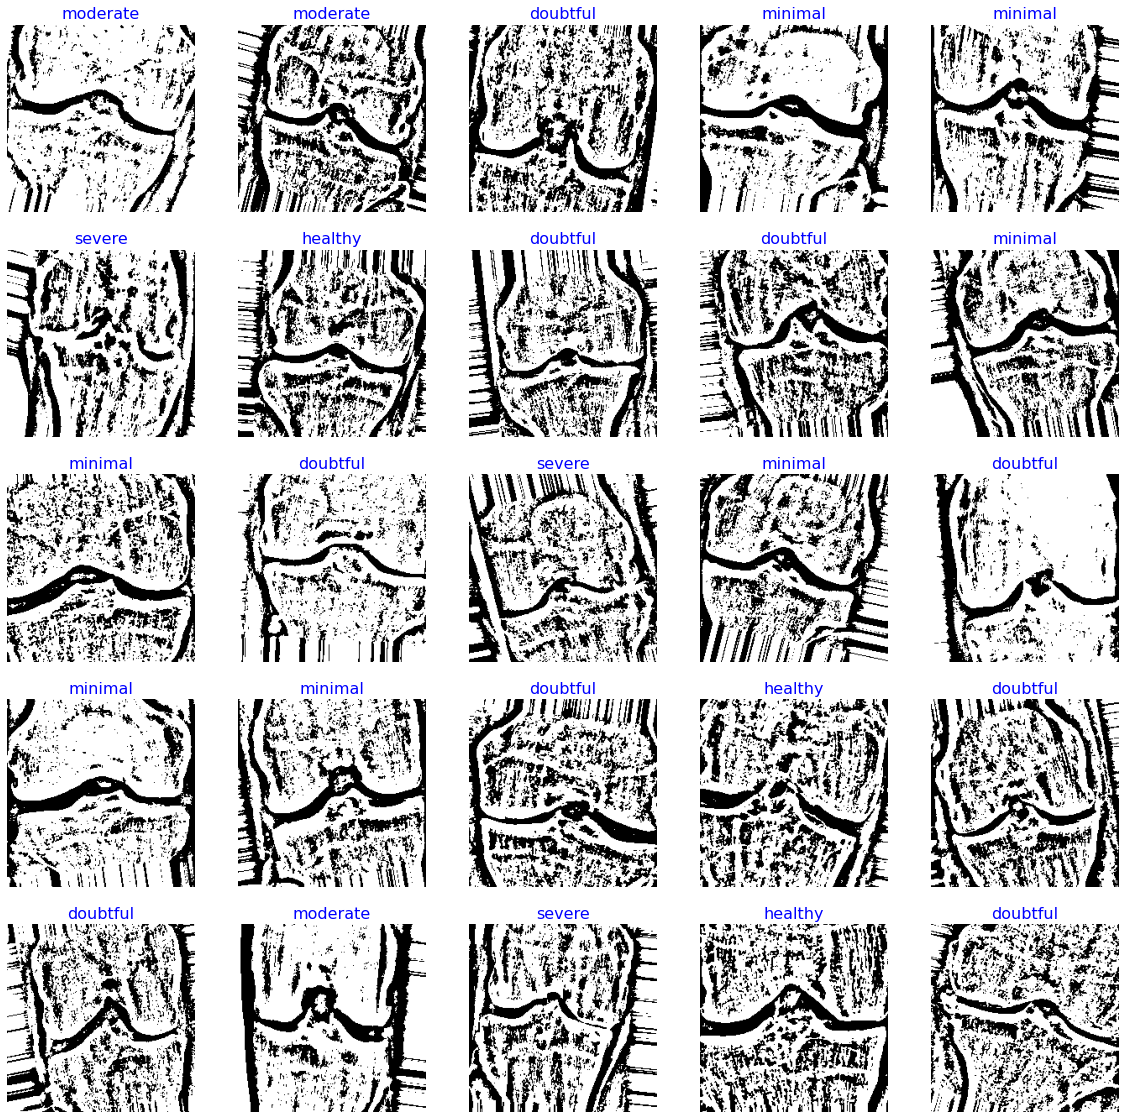

In [ ]:
show_image_samples(train_gen, class_names)

### create the model

In [ ]:
height=224
width=224
img_shape=(height, width, 3)
dropout=.3
lr=.001
img_shape=(height, width, 3)
base_model=tf.keras.applications.InceptionResNetV2( include_top=False, input_shape=img_shape, pooling='max', weights='imagenet') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)
x=Dropout(rate=dropout, seed=123)(x)        
output=Dense(class_count, activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

219055592/219055592 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adamax.py:95: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


### define handy function to print text in RGB foreground and background colors

In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):

    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

### create subclass of Keras callbacks for control of learning rate

In [ ]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,end_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience 
        self.stop_patience=stop_patience
        self.threshold=threshold 
        self.factor=factor 
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) 
        self.highest_tracc=0.0 
        self.lowest_vloss=np.inf 
        self.count=0 
        self.stop_count=0 
        self.end_epoch=end_epoch 
        best_weights=self.model.get_weights() 
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
            
    def on_epoch_begin(self, epoch, logs=None): 
        if epoch != 0:
            msgs=f'for epoch {epoch} '
            msgs=msgs + LRA.msg
            print_in_color(msgs, (255,255,0), (55,65,80))
            
    def reset(final_epoch):
        LRA.end_epoch=final_epoch-1
        LRA.count=0 
        LRA.stop_count=0 
        print (' ******  callback has been reset  ******')
            
    def on_epoch_end(self, epoch, logs=None):  
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
        v_loss=logs.get('val_loss')  
        acc=logs.get('accuracy')  
        
        if acc < self.threshold: 
            if acc>self.highest_tracc: 
                LRA.msg= f' training accuracy improved from  {self.highest_tracc:7.4f} to {acc:7.4f} learning rate held at {lr:10.8f}'
                self.highest_tracc=acc 
                LRA.best_weights=self.model.get_weights() 
                self.count=0 
                self.stop_count=0 
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss             
            else: 
                
                if self.count>=self.patience -1:
                    self.lr= lr* self.factor 
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) 
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights)                 
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss
                    msgs=f' training accuracy {acc:7.4f} < highest accuracy of {self.highest_tracc:7.4f} '
                    LRA.msg=msgs + f' for {self.patience } epochs, lr adjusted to {self.lr:10.8f}'                    
                else:
                    self.count=self.count +1
                    LRA.msg=f' training accuracy {acc:7.4f} < highest accuracy of {self.highest_tracc:7.4f} '
                   
        else: 
            if v_loss< self.lowest_vloss: 
                msgs=f' validation loss improved from {self.lowest_vloss:8.5f} to {v_loss:8.5}, saving best weights'
                LRA.msg=msgs + f' learning rate held at {self.lr:10.8f}'
                
                self.lowest_vloss=v_loss             
                LRA.best_weights=self.model.get_weights() 
                self.count=0 
                self.stop_count=0                    
            else: 
                if self.count>=self.patience-1:
                    self.lr=self.lr * self.factor 
                    self.stop_count=self.stop_count + 1         
                    msgs=f' val_loss of {v_loss:8.5f} > {self.lowest_vloss:8.5f} for {self.patience} epochs'
                    LRA.msg=msgs + f', lr adjusted to {self.lr:10.8f}'
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) 
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) 
                else: 
                    self.count =self.count +1 
                    LRA.msg=f' validation loss of {v_loss:8.5f} > {self.lowest_vloss:8.5f}'
                   
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        if epoch==self.end_epoch:
            print_in_color(LRA.msg, (255,255,0), (55,65,80)) 
        if self.stop_count> self.stop_patience - 1: 
            LRA.msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(LRA.msg, (0,255,0), (55,65,80))
            self.model.stop_training = True 

In [ ]:
patience=1      # epochs to wait to lower learning rate is metric does not improve
stop_patience=3  # consecutive epochs to wait without metric improvement before stopping training
threshold=.9    # define level of training accuracy that must be achieved before switching to monitor validation loss
factor=.5       # define value to multiply current learning rate by  to get lower learning rate if metric did not improve
dwell=False     # wxperimental- if metric for current metric did not improve set weights back to those of previous epoch
model_type='InceptionResNetV2'  # model selection name
freeze=True     # if True base model weights are frozen in training
epochs=12       # number of epochs to dun

callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_type, freeze=freeze, end_epoch=epochs - 1 )]

 Starting training using  base model InceptionResNetV2 with weights frozen to imagenet weights initializing LRA callback



##model train

In [ ]:
history=model.fit(train_gen, epochs=epochs, validation_data= valid_gen, callbacks=callbacks, verbose=1, class_weight=class_weight)

Epoch 1/12
 1/52 [..............................] - ETA: 52:39 - loss: 16.0897 - accuracy: 0.2333

In [ ]:
def tr_plot(tr_data, start_epoch):
    
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()


In [ ]:
tr_plot(history, 0)  

In [ ]:
def display_eval_metrics(e_data):
    msg='Model Metrics after Training'
    print_in_color(msg, (255,255,0), (55,65,80))
    msg='{0:^24s}{1:^24s}'.format('Metric', 'Value')
    print_in_color(msg, (255,255,0), (55,65,80))
    for key,value in e_data.items():
        print (f'{key:^24s}{value:^24.5f}')
    acc=e_data['accuracy']* 100
    return acc

### evaluate the model and save the model

In [ ]:
save_dir=r'./'
subject='knees'
model.set_weights(LRA.best_weights) 
e_dict=model.evaluate( test_gen, batch_size=test_batch_size, steps=test_steps, verbose=1,  return_dict=True)
acc=display_eval_metrics(e_dict)
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_type +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

In [ ]:
base_model.trainable=True
freeze=False
fine_tune_epochs=15
total_epochs=epochs + fine_tune_epochs
LRA.reset(total_epochs)
history=model.fit(train_gen, epochs=total_epochs, validation_data= valid_gen, callbacks=callbacks, verbose=2, initial_epoch=epochs, class_weight=class_weight)
tr_plot(history, epochs)  
e_dict=model.evaluate( test_gen, batch_size=test_batch_size, steps=test_steps, verbose=1,  return_dict=True)
acc=display_eval_metrics(e_dict)
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_type +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             
    
    classes=list(new_dict.values())     
    classes=['minimal', 'healthy', 'moderate', 'doubtful', 'severe']
    print ('*** classes ', classes)
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  
        if pred_index != true_index: 
            file_id=os.path.split(file_names[i])[1]
            error_list.append(file_id)
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                          
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) 
                plot_class.append(value)  
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    if len(classes)<= 20:
       
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width=length
            fig_height=length
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

In [ ]:
preds=model.predict(test_gen, batch_size=test_batch_size, verbose=0, steps=test_steps)
print_code=10
print_info(  test_gen, preds, print_code, save_dir, subject ) 